In [19]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2
import pandas as pd

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

import skimage
from skimage import measure

from PIL import Image
import scipy

import imresize

In [2]:
from srcnn import *
from utility import *

%matplotlib inline

In [3]:
#Division by 4
window_size= 64
scale = 4
stride = 16

In [4]:
def calcPSNR(original,prediction):
    return measure.compare_psnr(original, prediction,data_range=255)

In [5]:
def calcSSIM(orig,pred):
    return measure.compare_ssim(orig,pred,data_range=255, multichannel=True)

In [6]:
def calcRMSE(orig,pred):
    return np.sqrt(measure.compare_mse(orig,pred))

In [7]:
#Returns original, bicubic and model prediction
def getImages(filename):
    im = Image.open("set14/"+filename)

    img = np.asarray(im.convert('YCbCr'))

    img = img[:,:,0]
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = model.predict(low_wavelet)
    
    res = low_wavelet + pred_w

    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic,im

In [8]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]
	
	#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')
		
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]
				
def retSize(x):
    return (x.shape[0], x.shape[1])
	
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)



In [9]:
PATH = ""
TRAIN_FILE = PATH + "set14/"
obj_files = sorted(listdir(TRAIN_FILE )) #the filenames  the call to sorted is actually necessary to ensure independence to filesystems

In [10]:
high_res=obj_files[0::2]
low_res=obj_files[1::2]

In [16]:
img = Image.open("set14/"+high_res[10])
img=np.asarray(img)

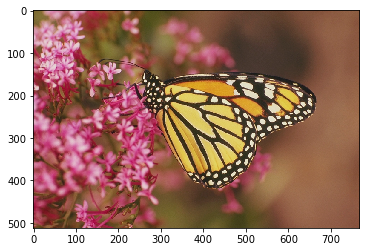

In [17]:
plt.imshow(img)

<h2>SciPy</h2>

In [20]:
scale=3
img = cv2.imread("set14/"+high_res[10])
size = img.shape

im_temp = scipy.misc.imresize(img, 1/scale, interp='bicubic')
im_input = scipy.misc.imresize(im_temp, size, interp='bicubic')
print(calcPSNR(img,im_input))

28.1598278678


<h2>OpenCV</h2>

In [31]:
height=img.shape[0]
width=img.shape[1]

In [32]:
org,bic=get_input_images(img, scale)

In [33]:
print(calcPSNR(org,bic))

26.6626301918


<h2>Custom ImResize</h2>

In [34]:
low_res=imresize.imresize(img,scalar_scale=scale)

In [35]:
high_res=imresize.imresize(low_res,output_shape=[height,width])

In [36]:
calcPSNR(img,high_res)

43.690756189906381